#Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd drive


/content/drive


In [4]:
cd MyDrive

/content/drive/MyDrive


In [5]:
cd PU-GCN-pytorch-master

/content/drive/MyDrive/PU-GCN-pytorch-master


#Start

In [6]:
import os

import torch

os.environ["TORCH"] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
!pip install omegaconf einops open3d class_resolver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 122.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.7 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=78f3f84581ed448d65f01aa2b240cb2b60e5b5367978e06a7c3f4ad4dcff3002
  Stored in directory: /root/.cache/pip/wheels/

In [8]:

from datetime import datetime

# utils
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric
from torch_geometric.utils import to_dense_batch
from tqdm.notebook import tqdm

import sys

from omegaconf import OmegaConf

%load_ext autoreload
%autoreload 2

In [9]:
print(torch.__version__)
print(torch_geometric.__version__)

2.1.0+cu118
2.4.0


## Utils

In [10]:
pip install hausdorff

  Preparing metadata (setup.py) ... done
  Created wheel for hausdorff: filename=hausdorff-0.2.6-py3-none-any.whl size=15187 sha256=05270ca360a8b28a8a7427dfab640d071f859dcdf6ddfb26b4aa9761a2a00b7a
  Stored in directory: /root/.cache/pip/wheels/cd/9e/ee/d7c81175a113c77a1169316da33a6491b29920365dc001256a
Successfully built hausdorff


In [11]:
from utils import model_size
from utils.losses import chamfer_dist_repulsion, density_chamfer_dist, chamfer_distance

from torch_geometric.loader import DataLoader as PyGLoader
from utils.data import PairData, PCDDataset, load_h5_data
from utils.viz import viz_many, viz_many_mpl
from utils.data import load_xyz_file
from utils.viz import draw_point_cloud

In [12]:
pip install pypcd

  Preparing metadata (setup.py) ... done
  Created wheel for python-lzf: filename=python_lzf-0.2.4-cp310-cp310-linux_x86_64.whl size=18223 sha256=ebe694475f5fa078cf988ee7e6e1af11e17b8cba56027624435049d03a3b69d3
  Stored in directory: /root/.cache/pip/wheels/08/99/38/ced814280db9c1bbbd47d3186b7a926a70c3d47da0c6e66c17
Successfully built python-lzf


### Configs

In [13]:
from omegaconf import OmegaConf

In [14]:
data_path = os.path.join( "data", "PU1K", "train", "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5")

exp_conf = OmegaConf.load(os.path.join("conf", "pugcn_config.yaml"))
model_config = exp_conf.model_config
train_config = exp_conf.train_config
data_config = exp_conf.data_config

In [15]:
print(OmegaConf.to_yaml(exp_conf))

name: pugcn-baseline
model_config:
  r: 4
  k: 20
  dilations:
  - 1
  - 2
  n_idgcn_blocks: 1
  channels: 24
  n_dgcn_blocks: 2
  use_bottleneck: true
  use_pooling: true
  use_residual: true
  conv: edge
  pool_type: mean
  dynamic: false
  use_refiner: true
  upsampler: nodeshuffle
  hierarchical: false
train_config:
  batch_size: 8
  epochs: 10
  optimizer: adam
  lr: 0.001
  betas:
  - 0.9
  - 0.999
  save_every: 5
  augment: true
  loss_fn: cd
  k_loss: 4
data_config:
  path: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
  num_point: 256
  skip_rate: 1
  use_randominput: true
  rng_seed: 42



# Data

In [16]:
# Load dataset
dataset = PCDDataset.from_h5(
    data_path,
    num_point=data_config.num_point,
    up_ratio=model_config.r,
    skip_rate=data_config.skip_rate,
    seed=data_config.rng_seed,
)

h5_filename :  data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 69000 samples


In [17]:
# Check one sample
data = dataset[42]
data_cloud, gt_cloud = data.pos_s, data.pos_t

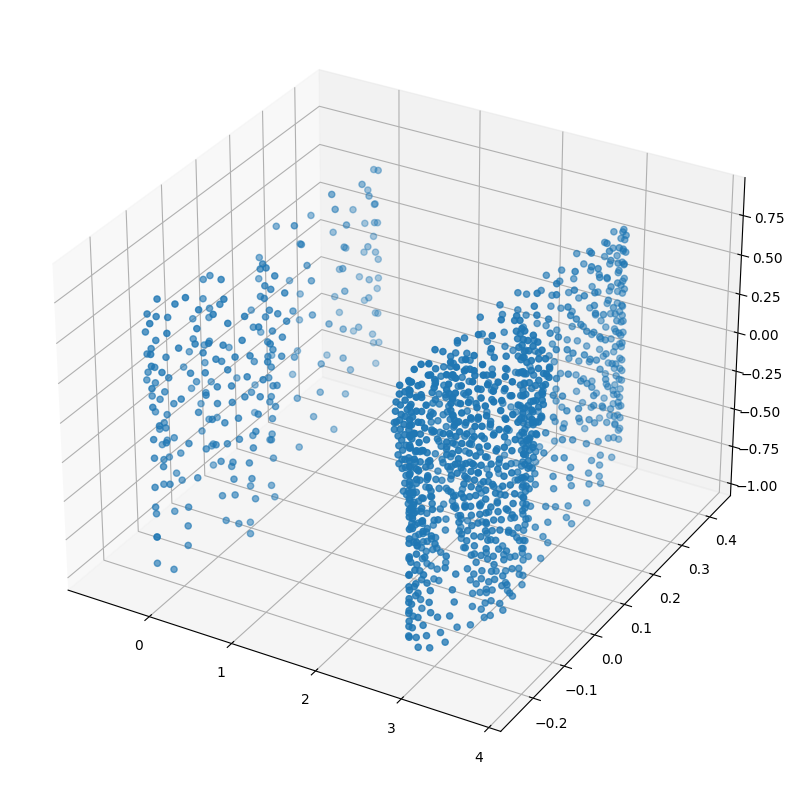

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
viz_many_mpl([data_cloud, gt_cloud], ax=ax)

# Training

In [19]:
from pugcn_lib import PUGCN, PUInceptionTransformer
from pugcn_lib.models import JustUpsample

In [20]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [21]:
# Split into train and validation if you wish
# train_perc = .8
# trainset, valset = torch.utils.data.random_split(dataset , [int(len(dataset) * train_perc), int(len(dataset) * (1-train_perc)+1)], generator=torch.Generator().manual_seed(42))

In [22]:
# Set augmentation for the datasets
dataset.augment = train_config.augment
# trainset.dataset.augment = True
# valset.dataset.augment = False

In [23]:
trainloader = PyGLoader(dataset, batch_size=train_config.batch_size, follow_batch=["pos_s", "pos_t"])
# trainloader = PyGLoader(trainset, batch_size=train_config.batch_size, follow_batch=['pos_s', 'pos_t'])
# valloader = PyGLoader(valset, batch_size=train_config.batch_size, shuffle=False, follow_batch = ['pos_s', 'pos_t'])

In [24]:
model = PUGCN(**model_config).to(device)
# model = JustUpsample(**model_config).to(device)
# loss_fn = loss_fn = ChamferLoss()
loss_fn = train_config.loss_fn
optimizer = torch.optim.Adam(params=model.parameters(), lr=train_config.lr, betas=train_config.betas)

In [25]:
torch.compile(model)

OptimizedModule(
  (_orig_mod): PUGCN(
    (feature_extractor): InceptionFeatureExtractor(
      (pre_gcn): GraphConv(
        (gconv): EdgeConv(nn=MLP(6, 24))
      )
      (layers): ModuleList(
        (0): InceptionDenseGCN(
          (bottleneck): MLP(24, 8)
          (dense_gcns): ModuleList(
            (0-1): 2 x DenseGCN(
              (lin_x): Linear(in_features=8, out_features=8, bias=True)
              (blocks): ModuleList(
                (0): GraphConv(
                  (gconv): EdgeConv(nn=MLP(16, 8))
                )
                (1): GraphConv(
                  (gconv): EdgeConv(nn=MLP(32, 8))
                )
              )
              (lin_down): Linear(in_features=24, out_features=8, bias=True)
            )
          )
        )
      )
    )
    (upsampler): GeneralUpsampler(
      (upsampler): NodeShuffle(
        (gcn): GraphConv(
          (gconv): EdgeConv(nn=MLP(48, 96))
        )
        (ps): PointShuffle()
        (lin): Linear(in_features=24, ou

In [26]:
pip install torchinfo

In [27]:
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                                                 Param #
PUGCN                                                                  --
├─InceptionFeatureExtractor: 1-1                                       --
│    └─GraphConv: 2-1                                                  --
│    │    └─EdgeConv: 3-1                                              168
│    └─ModuleList: 2-2                                                 --
│    │    └─InceptionDenseGCN: 3-2                                     1,544
├─GeneralUpsampler: 1-2                                                --
│    └─NodeShuffle: 2-3                                                --
│    │    └─GraphConv: 3-3                                             4,704
│    │    └─PointShuffle: 3-4                                          --
│    │    └─Linear: 3-5                                                600
├─Sequential: 1-3                                                      --
│    └─Linear: 2-4       

In [28]:
model_size(model, unit="KB")

39.898

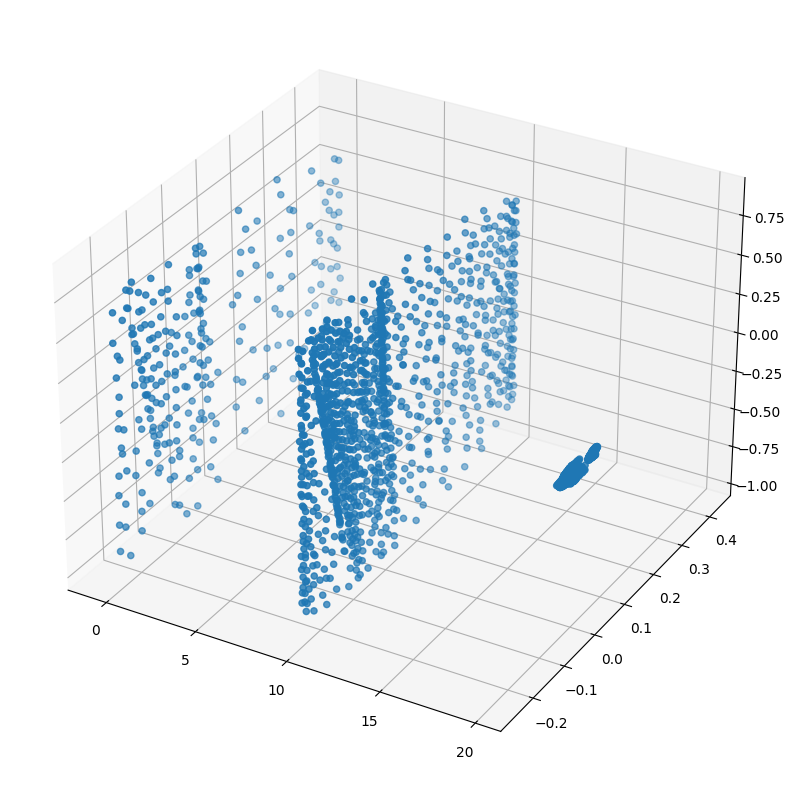

In [29]:
pred = model(data_cloud.to(device)).cpu().detach().numpy()
pred

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

viz_many_mpl([data_cloud, gt_cloud, pred], d=10, ax=ax)

In [30]:
def train(model, trainloader, loss_fn, optimizer, gamma=0, before_refiner_loss=False):

    total_loss = 0.0
    total_proportion = 0.0
    for (i, d) in (t := tqdm(enumerate(trainloader), total=len(trainloader))):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None

        # Train step
        optimizer.zero_grad()
        pred = model(p, batch=p_batch)

        # Transform to dense batches
        pred, _ = to_dense_batch(pred, q_batch)  # [B, N * r, 3]
        gt, _ = to_dense_batch(q, q_batch)  # # [B, N * r, 3]

        # Calculate loss
        if loss_fn == "dcd":
            dcd, _, _ = density_chamfer_dist(pred, gt)
            loss = dcd.mean()
        elif loss_fn == "cd":
            _, _, cd_t = density_chamfer_dist(pred, gt)
            loss = cd_t.mean()
        elif loss_fn == "cd_rep":
            loss, prop = chamfer_dist_repulsion(pred, gt, k=train_config.k_loss, return_proportion=True)
            total_proportion += prop
        else:
            raise ValueError('Loss must be "cd" or "dcd"')

        if before_refiner_loss:
            with torch.no_grad():
                pred2 = model.predict_unrefined(p, p_batch)
            pred2, _ = to_dense_batch(pred2, q_batch)
            if loss_fn == "dcd":
                dcd, _, _ = density_chamfer_dist(pred2, gt)
                loss2 = dcd.mean()
            elif loss_fn == "cd":
                _, _, cd_t = density_chamfer_dist(pred2, gt)
                loss2 = cd_t.mean()
            elif loss_fn == "cd_rep":
                loss2 = chamfer_dist_repulsion(pred2, gt, k=4)
            else:
                raise ValueError('Loss must be "cd" or "dcd"')
            loss = (1 - gamma) * loss + gamma * loss2

        if model_config.upsampler == "variational":
            mean = model.upsampler.upsampler.last_z_mean
            log_var = model.upsampler.upsampler.last_z_log_var
            kl_loss = (-0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var), dim=1)).mean()
            loss = (loss + kl_loss) / 2

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        t.set_description(
            f"loss = {total_loss / ((i+1) * trainloader.batch_size) :.8f}\tprop={total_proportion / ((i+1) * trainloader.batch_size ) :.4f}"
        )
        # t.set_description(f"loss = {total_loss / ((i+1) * trainloader.batch_size) :.8f}")
    return total_loss / len(trainloader.dataset)

In [31]:
if "trained-models" not in os.listdir("."):
    os.mkdir("trained-models")
dir_name = f'{datetime.now().strftime("%Y-%m-%d-%H-%M")}-{exp_conf.name}'

os.mkdir(os.path.join("trained-models", dir_name))
print(f"Saving checkpoints at {dir_name}")

Saving checkpoints at 2023-11-28-05-35-pugcn-baseline


In [32]:
OmegaConf.save(config=exp_conf, f=os.path.join("trained-models", dir_name, "config.yaml"))

In [ ]:
history = OmegaConf.create()
history.train_loss = []
history.val_loss = []
for epoch in tqdm(range(1, train_config.epochs + 1)):

    train_loss = train(
        model, trainloader, loss_fn, optimizer, gamma=(1 - epoch / train_config.epochs), before_refiner_loss=False
    )
    # train_loss = train_w_refiner(model, trainloader, loss_fn, optimizer, alpha=0.5)
    history.train_loss.append(train_loss)
    # val_loss = evaluate(model, valloader, loss_fn)
    # history.val_loss.append(val_loss)

    print(f"{epoch=} \t {train_loss=:.6f}")

    if epoch == 1 or epoch % train_config.save_every == 0:
        torch.save(
            {
                "experiment_config": dict(exp_conf),
                "history": history,
                "epoch": epoch,
                "model_size": model_size(model, unit="KB"),
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            os.path.join("trained-models", dir_name, f"ckpt_epoch_{epoch}"),
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8625 [00:00<?, ?it/s]

In [ ]:
idx = np.random.choice(len(dataset))
# dv = valset[idx]
dv = dataset[idx]
sample, gt = dv.pos_s, dv.pos_t

In [ ]:
pred = model(sample.to(device)).cpu().detach().numpy()
pred

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
viz_many_mpl([sample, gt, pred], d=4, ax=ax)

In [ ]:
viz_many([sample, gt, pred], use_plotly=False)